В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
import pandas as pd
from process_bank_churn import preprocess_data, preprocess_new_data, plot_roc_curve, plot_confusion_matrix, f1_score

<h4><i>process_bank_churn</i> було змінено, було додано нові фічі, тому кількість змінних відрізняється, значення ROC AUC відповідно також</h4>

In [74]:
df = pd.read_csv('kaggle/train.csv')

In [75]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [76]:
info = preprocess_data(df)

/Users/bilukhan/ML course/Practice/process_bank_churn.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_inputs[numeric_cols] = scaler.fit_transform(train_inputs[numeric_cols])
/Users/bilukhan/ML course/Practice/process_bank_churn.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])


In [77]:
X_train = info.get('X_train')
y_train = info.get('y_train')
X_val = info.get('X_val')
y_val = info.get('y_val')
input_cols = info.get('input_cols')
scaler = info.get('scaler')
encoder = info.get('encoder')
woe_geography = info.get('woe_geography')

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [78]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

model.fit(X_train, y_train)

y_preds_train = model.predict_proba(X_train)[:, 1]
y_preds_val = model.predict_proba(X_val)[:, 1]

Area under ROC score on Train dataset: 96.43916087%


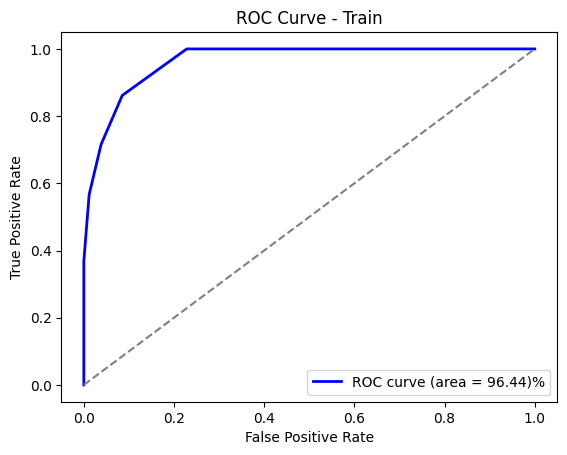

In [79]:
plot_roc_curve(y_train, y_preds_train, "Train")

Area under ROC score on Validation dataset: 88.42050209%


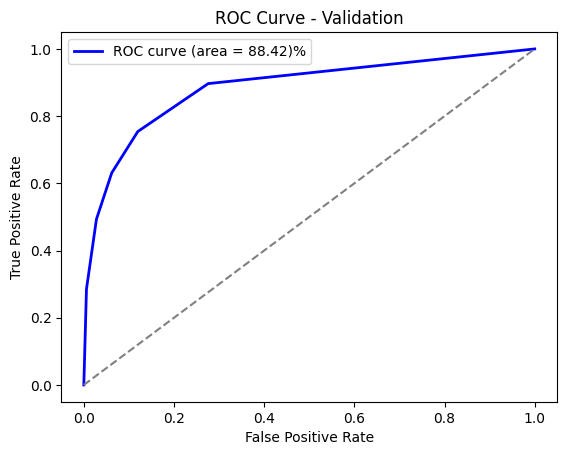

In [80]:
plot_roc_curve(y_val, y_preds_val, "Validation")

Значення ROC AUC для тренувального набору становить 96.44%, при цьому ROC AUC для валідаційного набору складає 88.42% в моделі високий варіанс, проте низький баєс. Модель перенавчилась

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [81]:
from sklearn.model_selection import GridSearchCV
import numpy as np

model = KNeighborsClassifier()
knn_params = {"n_neighbors": np.arange(1, 50, 1)}

knn_grid_search = GridSearchCV(model, knn_params, cv=5)
knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [82]:
display(knn_grid_search.best_estimator_, knn_grid_search.best_params_)

KNeighborsClassifier(n_neighbors=33)

{'n_neighbors': 33}

In [83]:
knn_best = knn_grid_search.best_params_.get("n_neighbors")

In [117]:
model = KNeighborsClassifier(n_neighbors=knn_best)

model.fit(X_train, y_train)

y_preds_train = model.predict_proba(X_train)[:, 1]
y_preds_val = model.predict_proba(X_val)[:, 1]

Area under ROC score on Train dataset: 93.82876499%


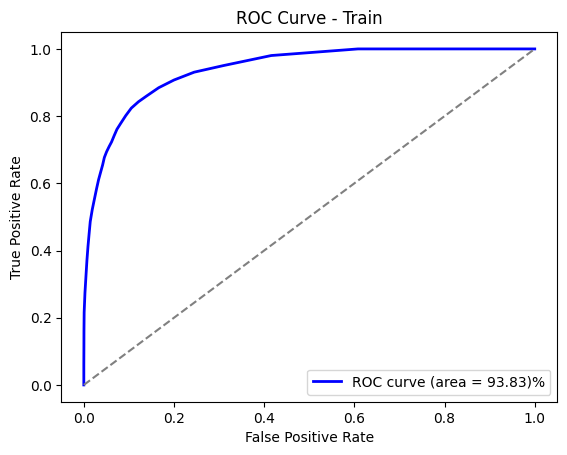

In [85]:
plot_roc_curve(y_train, y_preds_train, "Train")

Area under ROC score on Validation dataset: 92.09160436%


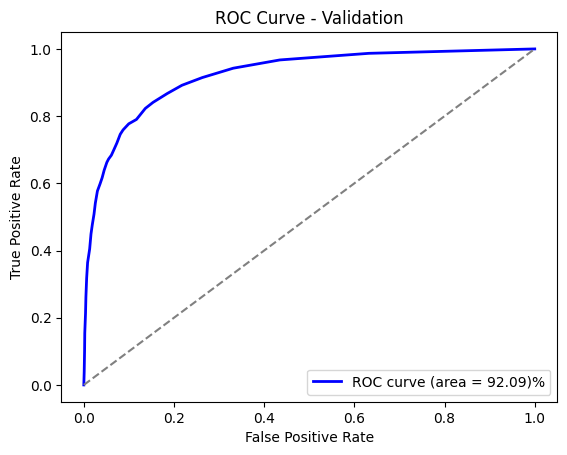

In [86]:
plot_roc_curve(y_val, y_preds_val, "Validation")

Порівнюючи з результатами `DecisionTreeClassifier`, `KNeighborsClassifier` показав трішки кращий результат, **на 0.04%** в обох випадках (train/val)

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [87]:
from sklearn.tree import DecisionTreeClassifier
import time

dtc = DecisionTreeClassifier()

dtc_params = {
    "max_depth": np.arange(1, 21, 2),
    "max_leaf_nodes": np.arange(2, 11, 1)
}
start_time = time.time()

dtc_grid_search = GridSearchCV(dtc, param_grid=dtc_params, cv=5, scoring='roc_auc')

dtc_grid_search.fit(X_train, y_train)

print(f"Processing time: {time.time() - start_time} seconds")

Processing time: 5.915405035018921 seconds


In [88]:
display(dtc_grid_search.best_estimator_, dtc_grid_search.best_params_)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)

{'max_depth': 5, 'max_leaf_nodes': 10}

In [103]:
dt_best = dtc_grid_search.best_params_

In [89]:
dtc = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10)

In [90]:
y_preds_train = dtc.predict_proba(X_train)[:, 1]
y_preds_val = dtc.predict_proba(X_val)[:, 1]

Area under ROC score on Train dataset: 90.14754782%


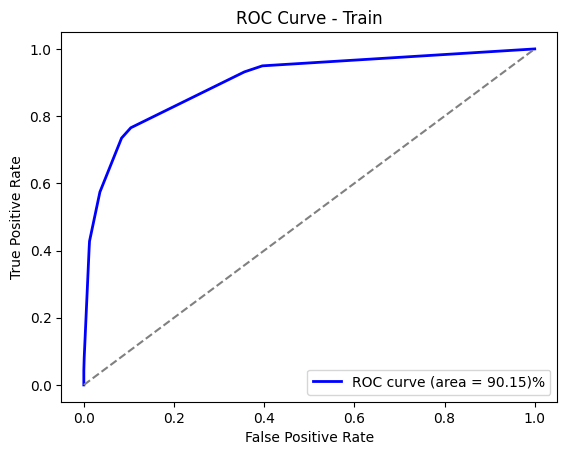

In [91]:
plot_roc_curve(y_train, y_preds_train, "Train")

Area under ROC score on Validation dataset: 90.02184649%


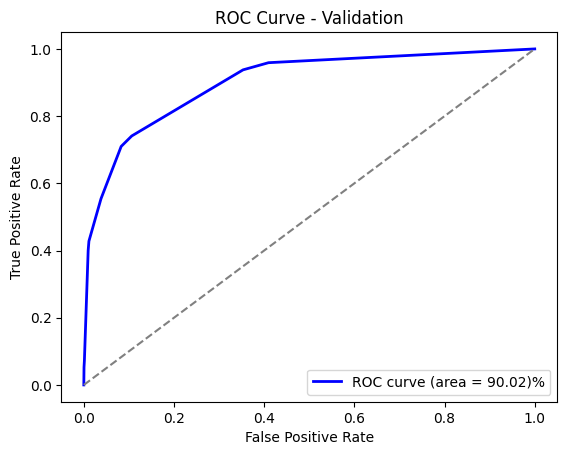

In [92]:
plot_roc_curve(y_val, y_preds_val, "Validation")

Досить цікаво, що `DecisionTreeClassifier` показав гірші результати, можливо модель краще "працює" із ймовірностями, потрібно перевірити додатково з іншими метриками, щоб підтвердити, що `KNeighborsClassifier` дійсно кращий за `DecisionTreeClassifier`. Перевіримо що метрику `f1_score`.

In [101]:
print(f"KNN Train: {f1_score(y_train, model.predict(X_train))}")
print(f"KNN Validation: {f1_score(y_val, model.predict(X_val))}")

print(f"DecisionTree Train: {f1_score(y_train, dtc.predict(X_train))}")
print(f"DecisionTree Validation: {f1_score(y_val, dtc.predict(X_val))}")

KNN Train: 0.7298013245033113
KNN Validation: 0.7112676056338029
DecisionTree Train: 0.6700119474313023
DecisionTree Validation: 0.6506256015399422


Дійсно, KNN показав кращі результати.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [102]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [107]:
from sklearn.model_selection import RandomizedSearchCV

model = DecisionTreeClassifier()
model_random_search = RandomizedSearchCV(model, n_iter=40, random_state=42, scoring='roc_auc', param_distributions=params_dt)
model_random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=40,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='roc_auc')

In [108]:
display(model_random_search.best_estimator_, model_random_search.best_params_)

DecisionTreeClassifier(criterion='entropy', max_depth=16, max_leaf_nodes=14,
                       min_samples_leaf=2, min_samples_split=20)

{'splitter': 'best',
 'min_samples_split': 20,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 14,
 'max_features': None,
 'max_depth': 16,
 'criterion': 'entropy'}

In [109]:
dt_random_search_best = model_random_search.best_params_

In [110]:
model = DecisionTreeClassifier(splitter=dt_random_search_best.get('splitter'),
                               min_samples_leaf=dt_random_search_best.get('min_samples_leaf'),
                               min_samples_split=dt_random_search_best.get('min_samples_split'),
                               max_leaf_nodes=dt_random_search_best.get('max_leaf_nodes'),
                               max_features=dt_random_search_best.get('max_features'),
                               max_depth=dt_random_search_best.get('max_depth'),
                               criterion=dt_random_search_best.get('criterion')
                              )

model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=16, max_leaf_nodes=14,
                       min_samples_leaf=2, min_samples_split=20)

In [111]:
y_preds_train = dtc.predict_proba(X_train)[:, 1]
y_preds_val = dtc.predict_proba(X_val)[:, 1]

Area under ROC score on Train dataset: 90.14754782%


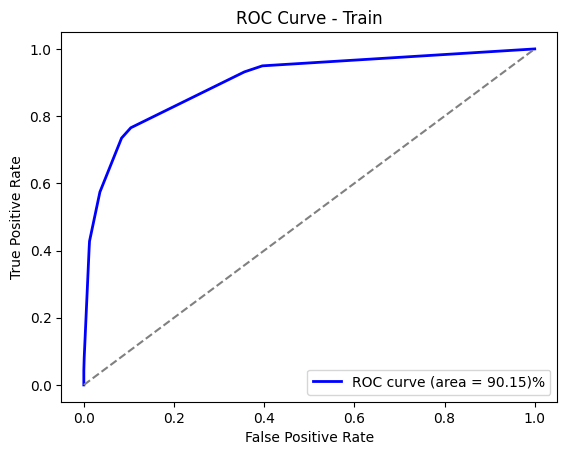

In [112]:
plot_roc_curve(y_train, y_preds_train, "Train")

Area under ROC score on Validation dataset: 90.02184649%


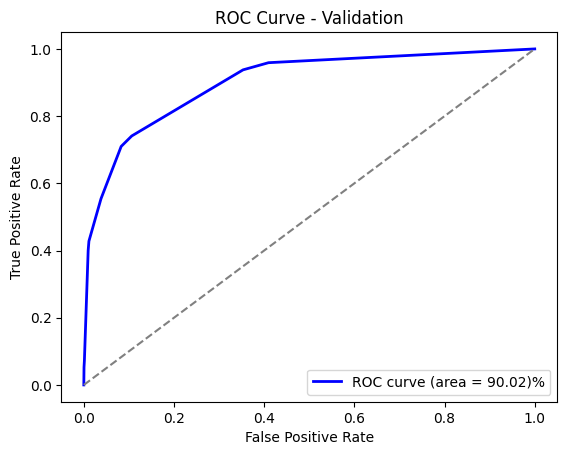

In [113]:
plot_roc_curve(y_val, y_preds_val, "Validation")

Модель не показала кращі результати, площа ROC складає 90.02%, що є меншим за ROC KNN та Логістичної регресії. Для впевненості, перевірю метрикою, яку я обрав для оцінки якості класифікації для змагання Kaggle, ROC AUC для передбачень класу (без ймовірностей).

Area under ROC score on Validation KNN dataset: 80.56245284%


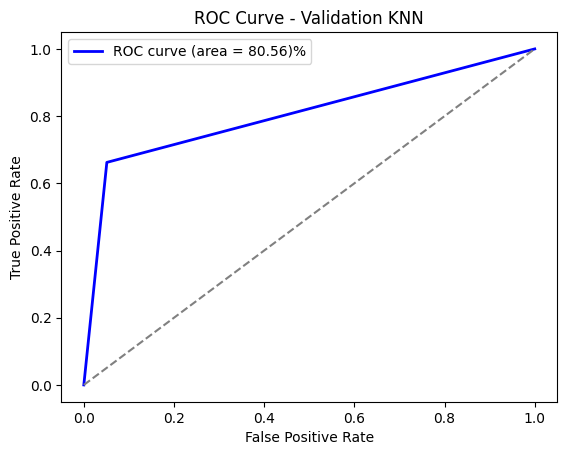

In [139]:
plot_roc_curve(y_val, model.predict(X_val), "Validation KNN")

Area under ROC score on Validation DecisionTreeClassifier dataset: 75.80115234%


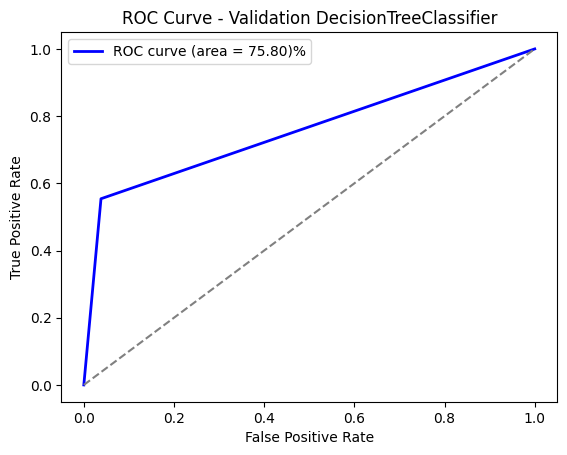

In [140]:
plot_roc_curve(y_val, dtc.predict(X_val), "Validation DecisionTreeClassifier")

Отже, ці моделі є гіршими, ніж Логістична регресія, її ROC AUC для передбачень на валідаційних даних (без ймовірностей) складає **0.85370739%**

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉